# Ingest Fashion MNIST

Convert [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) into tfrecord files

In [1]:
import os
import requests
import io
import gzip
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
# Switch to scratch data directory on local machine
!mkdir -p ~/data/braingeneers/fashion-mnist
os.chdir(os.path.expanduser("~/data/braingeneers/fashion-mnist"))

In [3]:
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2018-11-07 23:04:10--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.27
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: 'train-images-idx3-ubyte.gz'

train-images-idx3-u 100%[===================>]  25.20M  3.41MB/s    in 11s     

2018-11-07 23:04:21 (2.22 MB/s) - 'train-images-idx3-ubyte.gz' saved [26421880/26421880]

--2018-11-07 23:04:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.3
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaw

In [4]:
with gzip.open("train-labels-idx1-ubyte.gz", "rb") as f:
    train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

with gzip.open("train-images-idx3-ubyte.gz", "rb") as f:
    train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
    
with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as f:
    test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as f:
    test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)
    
print("Found {} train and {} test examples".format(len(train_images), len(test_images)))

Found 60000 train and 10000 test examples


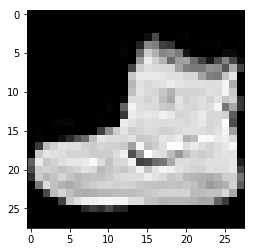

In [5]:
plt.imshow(train_images[0].reshape(28,28), cmap='gray')

In [6]:
!pip install --user --quiet imageio
import imageio
image = imageio.imwrite(imageio.RETURN_BYTES, train_images[0].reshape(28,28), format="PNG")

import IPython
IPython.display.Image(image)

In [7]:
def write_dataset(images, labels, dest):
    with tf.python_io.TFRecordWriter(dest) as writer:
        for image, label in zip(images, labels):
            writer.write(tf.train.Example(features=tf.train.Features(feature = {
                "example": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)]))
            })).SerializeToString())

write_dataset(
    [imageio.imwrite(imageio.RETURN_BYTES, i.reshape(28,28), format="PNG") for i in train_images],
    train_labels, "fashion-mnist-train.tfrecord")

write_dataset(
    [imageio.imwrite(imageio.RETURN_BYTES, i.reshape(28,28), format="PNG") for i in test_images],
    test_labels, "fashion-mnist-test.tfrecord")

In [32]:
import json
with open("metadata.json", "w") as f:
    f.write(json.dumps({
        "data_set": "fashion-mnist",
        "description": "https://github.com/zalandoresearch/fashion-mnist",
        "labels": sorted(list(set(int(l) for l in train_labels))),
        "train_examples_name": "fashion-mnist-train.tfrecord",
        "test_examples_name": "fashion-mnist-test.tfrecord",
        "num_train_examples": len(train_images),
        "num_test_examples": len(test_images),
        "image_width": 28,
        "image_height": 28
    }))

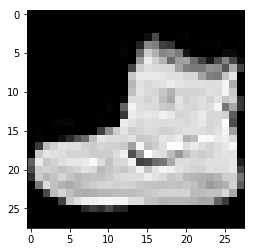

In [10]:
def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    return example["example"], tf.one_hot(example["label"], 10)

training_dataset = tf.data.TFRecordDataset(["fashion-mnist-train.tfrecord"])

# Extract and display first image
# https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding
example, label = parse_one_example(training_dataset.make_one_shot_iterator().get_next())
image = tf.image.decode_image(example)

assert metadata["image_width"] == image.shape[1].value
assert metadata["image_height"] == image.shape[0].value

plt.imshow(image.numpy().reshape(image.shape[0], image.shape[1]), cmap='gray')

# Upload to S3

These files are now accessible publicly external to the PRP under 

https://s3.nautilus.optiputer.net/braingeneers/simulated/
    
and internal to the PRP at the endpoint:

s3://rook-ceph-rgw-rooks3.rook

In [19]:
# Empty the path
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 rm --recursive s3://braingeneers/fashion-mnist

In [33]:
# Use the aws cli's rsync like sync command to push changed files up to PRP S3/CEPH
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 sync . s3://braingeneers/fashion-mnist --acl public-read

upload: ./metadata.json to s3://braingeneers/fashion-mnist/metadata.json


In [31]:
!aws --profile {os.getenv("AWS_PROFILE")} --endpoint {os.getenv("AWS_S3_ENDPOINT")} \
    s3 ls s3://braingeneers/fashion-mnist/

2018-11-07 23:08:34    5622886 fashion-mnist-test.tfrecord
2018-11-07 23:08:36   33630997 fashion-mnist-train.tfrecord
2018-11-07 23:08:34        313 metadata.json
2018-11-07 23:08:34    4422102 t10k-images-idx3-ubyte.gz
2018-11-07 23:08:34       5148 t10k-labels-idx1-ubyte.gz
2018-11-07 23:08:36   26421880 train-images-idx3-ubyte.gz
2018-11-07 23:08:34      29515 train-labels-idx1-ubyte.gz


## Reload and Display

Load the dataset directly from S3 and verify we can visualize and image

In [2]:
import requests

metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/fashion-mnist/metadata.json").json()
metadata.keys()

dict_keys(['test_examples_name', 'data_set', 'description', 'image_height', 'image_width', 'labels', 'num_train_examples', 'train_examples_name', 'num_test_examples'])

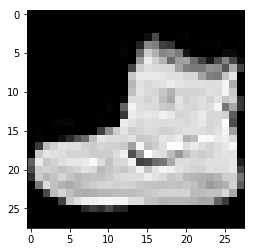

In [11]:
def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    return example["example"], tf.one_hot(example["label"], len(metadata["labels"]))

training_dataset = tf.data.TFRecordDataset(["s3://braingeneers/fashion-mnist/fashion-mnist-train.tfrecord"])

# Extract and display first image
# https://www.tensorflow.org/api_guides/python/image#Encoding_and_Decoding
example, label = parse_one_example(training_dataset.make_one_shot_iterator().get_next())
image = tf.image.decode_image(example)

assert metadata["image_width"] == image.shape[1].value
assert metadata["image_height"] == image.shape[0].value

plt.imshow(image.numpy().reshape(image.shape[0], image.shape[1]), cmap='gray')